# Intercranial Hemorrhage (ICH) Subtypes Detection Project

**Notebook Content**

1. [Description](#Description)
2. [Import Libraries](#Import-Libraries)
3. [Data Exploration](#Data-Exploration)
    - 3.1 [Data Cleaning](#Data-Cleaning)
        - 3.1.1 [Declaring Data Paths](#Declaring-Data-Paths)
        - 3.1.2 [Reading Data](#Reading-Data)
        - 3.1.3 [Check Null Values](#Check-Null-Values)
        - 3.1.4 [Check Duplicates](#Check-Duplicates)
        - 3.1.5 [Data Reformatting](#Data-Reformatting)
    - 3.2 [Data Visualization](#Data-Visualization)
        - 3.2.1 [Distribution of the normal and ubnormal exams](#Distribution-of-the-normal-and-ubnormal-exams)
        - 3.2.2 [Distribution of the hemorrhage subtypes](#Distribution-of-the-hemorrhage-subtypes)
4. [DICOM Handling](#DICOM-Handling)
    - 4.1 [Read DICOM File](#Read-DICOM-File)
    - 4.2 [Visualize 3 images for each subtype and normal exams](#Visualize-3-images-for-each-subtype-and-normal-exams)
    - 4.3 [DICOM Preprocessing](#DICOM-Preprocessing)
        - 4.3.1 [Correcting Winow](#Correcting-Window)
        - 4.3.2 [Removing Noise](#Removing-Noise)
        - 4.3.3 [Cropping and Padding](#Cropping-and-Padding)
        - 4.3.4 [Put Them Together](#Put-Them-Together)

## **1. Description** <a id='Description'></a>
**Intraparenchymal hemorrhage (ICH)** refers to bleeding that occurs within the skull, specifically within the brain or its surrounding structures. This condition is typically severe and can pose life-threatening risks if not managed promptly and properly. The consequences can be devastating, often leading to long-term disabilities or death.

The different types of intracranial hemorrhage are primarily categorized based on the location of the bleeding within the brain:

**1- Intracerebral Hemorrhage (ICH):** This type of hemorrhage occurs within the brain tissue itself. Hypertension (high blood pressure) is a common cause, but it can also result from other conditions such as brain tumors, vascular malformations, or blood clotting disorders.

**2- Intraventricular Hemorrhage (IVH):** IVH is bleeding into the ventricles, the fluid-filled cavities within the brain. This type of hemorrhage is particularly common in premature infants but can also occur in adults, often in conjunction with other types of ICH.

**3- Subarachnoid Hemorrhage (SAH):** This involves bleeding into the subarachnoid space, which is between the arachnoid and the pia mater (the innermost layer of the meninges). It is most often caused by a ruptured cerebral aneurysm, leading to a sudden, severe headache (often described as "the worst headache of my life").

**4- Subdural Hemorrhage (SDH):** SDH is bleeding that takes place between the dura mater and the arachnoid layer of the meninges (the membranes that cover the brain). It usually arises from a tear in the bridging veins that connect the brain to the dura. SDH can be acute, subacute, or chronic based on the rate of blood accumulation.

**5- Epidural Hemorrhage (EDH):** This type of hemorrhage occurs between the outer layer of the brain (dura mater) and the skull. It is often the result of a severe head injury that causes a tear in an artery, commonly the middle meningeal artery.



![image](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F603584%2F56162e47358efd77010336a373beb0d2%2Fsubtypes-of-hemorrhage.png?generation=1568657910458946&alt=media)
Ref: https://www.kaggle.com/competitions/rsna-intracranial-hemorrhage-detection/overview/hemorrhage-types

## **2. Import Libraries** <a id='Import-Libraries'></a>

In [1]:
!pip install numpy pandas matplotlib seaborn pydicom opencv-contrib-python

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pydicom
import random
import os
from pathlib import Path
import cv2
import warnings
warnings.filterwarnings("ignore")

## **3. Data Exploration** <a id='Data-Exploration'></a>

### **3.1 Data Cleaning** <a id='Data-Cleaning'></a>
#### **3.1.1 Declaring Data Paths** <a id='Declaring-Data-Paths'></a>

In [3]:
CUR_PATH = Path().absolute()
ROOT_DATA_DIR = Path("/kaggle/input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection")
TRAINING_IMAGES_PATH = Path("stage_2_train")
TRAINING_CSV_PATH = Path("stage_2_train.csv")

#### **3.1.2 Reading Data** <a id='Reading-Data'></a>

In [4]:
train_df = pd.read_csv(ROOT_DATA_DIR/TRAINING_CSV_PATH)
train_df.head(10)

,ID,Label
0,ID_12cadc6af_epidural,0
1,ID_12cadc6af_intraparenchymal,0
2,ID_12cadc6af_intraventricular,0
3,ID_12cadc6af_subarachnoid,0
4,ID_12cadc6af_subdural,0
5,ID_12cadc6af_any,0
6,ID_38fd7baa0_epidural,0
7,ID_38fd7baa0_intraparenchymal,0
8,ID_38fd7baa0_intraventricular,0
9,ID_38fd7baa0_subarachnoid,0


In [5]:
train_df.shape

(4516842, 2)

#### **3.1.3 Check Null Values** <a id='Check-Null-Values'></a>

In [6]:
train_df.isnull().sum()

ID       0
Label    0
dtype: int64

#### **3.1.4 Check Duplicates** <a id='Check-Duplicates'></a>

In [7]:
train_df.duplicated().sum()

24

In [8]:
train_df.drop_duplicates(inplace=True)

#### **3.1.5 Data Reformatting** <a id='Data-Reformatting'></a>
Regarding the dataframe above, It contains six rows for the same dicom file. Each row contains DicomPath and subtype label.

Recreating the dataframe with Dicom Path and its subtype in two seperated columns.

In [9]:
def recreate_table(df, splitter = "_"):
    """
    
    This function is used for recreating table with the right shape of path and labels
    
        Parameters:
            df (Datframe) : The dataframe that has two columns ID = "ID_<filename>_<subtype>", label = 0 or 1
            splitter(str) : the splitter used to split the ID string
    
        Returns:
            new_df (Dataframe): a new dataframe with the right shape
            
    """
    new_df = df.copy()
    new_df["file_name"] = new_df["ID"].str.split(splitter, n=2, expand=True)[1]
    new_df["Subtype"] = new_df["ID"].str.split(splitter, n=2, expand=True)[2]
    new_df["ID"] = new_df["file_name"].apply(lambda name: "ID_"+name+".dcm")
    new_df.drop("file_name", axis=1, inplace=True)
    new_df_pivot = new_df.pivot(index = "ID", columns="Subtype", values="Label")
    new_df_pivot.reset_index(inplace=True)
    new_df_pivot.rename_axis(None, axis=1, inplace=True)
    return new_df_pivot

train_df_new = recreate_table(train_df)

In [10]:
train_df_new.head(20)

,ID,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
0,ID_000012eaf.dcm,0,0,0,0,0,0
1,ID_000039fa0.dcm,0,0,0,0,0,0
2,ID_00005679d.dcm,0,0,0,0,0,0
3,ID_00008ce3c.dcm,0,0,0,0,0,0
4,ID_0000950d7.dcm,0,0,0,0,0,0
5,ID_0000aee4b.dcm,0,0,0,0,0,0
6,ID_0000ca2f6.dcm,0,0,0,0,0,0
7,ID_0000f1657.dcm,0,0,0,0,0,0
8,ID_000178e76.dcm,0,0,0,0,0,0
9,ID_00019828f.dcm,0,0,0,0,0,0


### **3.2 Data Visualization** <a id='Data-Visualization'></a>

#### **3.2.1 Distribution of the normal and ubnormal exams** <a id='Distribution-of-the-normal-and-ubnormal-exams'></a>

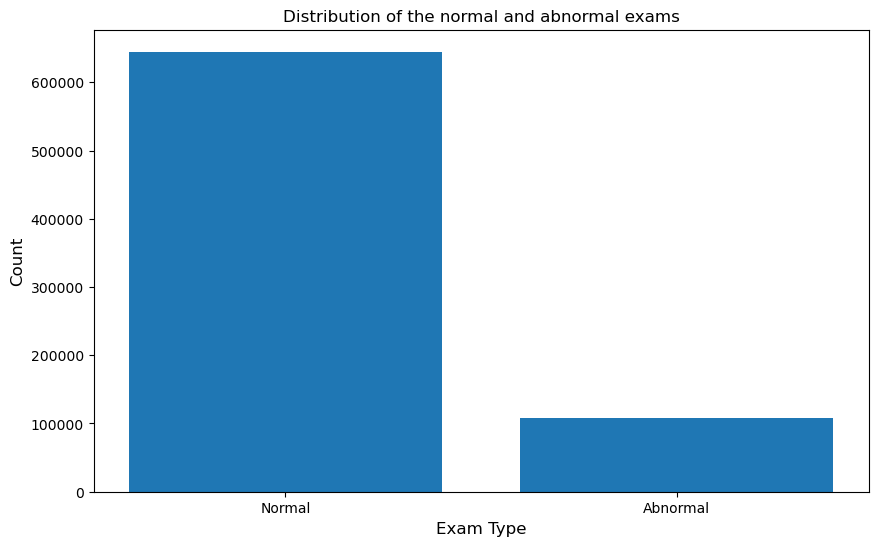

In [11]:
# Create a sns barplot to show the distribution of the labels
plt.figure(figsize=(10, 6))
plt.bar(x=["Normal", "Abnormal"], height=train_df_new["any"].value_counts().values)
plt.title("Distribution of the normal and abnormal exams", fontsize=12);
plt.xlabel("Exam Type", fontsize=12);
plt.ylabel("Count", fontsize=12);

As realized from the graph, the dataset is imbalanced. The normal exams are more 6 times than ubnormal exams . This is a common problem in medical datasets. We will deal with this problem later.


#### **3.2.2 Distribution of the hemorrhage subtypes** <a id='Distribution-of-the-hemorrhage-subtypes'></a>

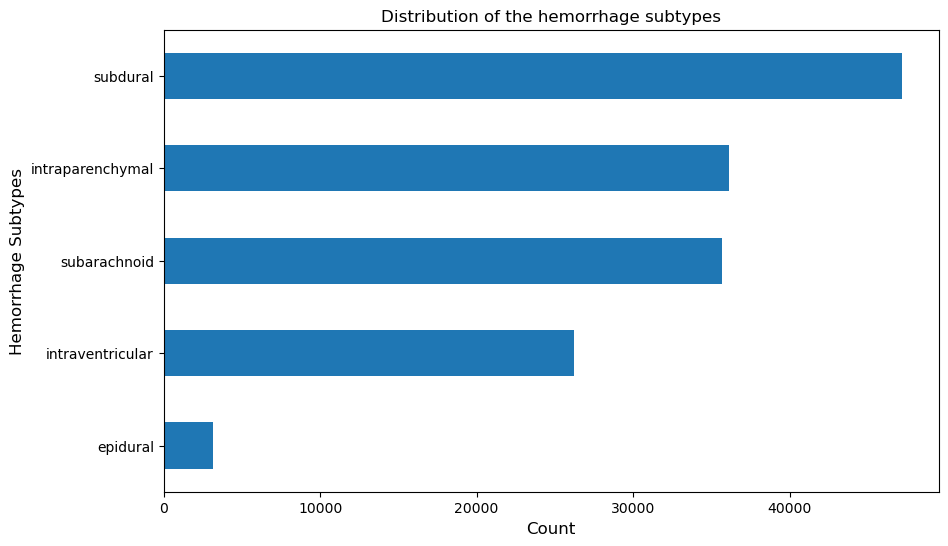

In [12]:
# visualize barplot for each subtype in the same graph
fig = plt.figure(figsize=(10, 6))
# sort the values in ascending order
train_df_new.iloc[:, 2:].sum().sort_values(ascending=True).plot(kind="barh")
plt.xlabel("Count", fontsize=12);
plt.ylabel("Hemorrhage Subtypes", fontsize=12);
plt.title("Distribution of the hemorrhage subtypes", fontsize=12);

Regarding the hemorrhage subtypes plot, there is unbalance between them specially the subtype "epidural". We will deal with this problem later.


## **4. DICOM Handling** <a id='DICOM-Handling'></a>

**DICOM (Digital Imaging and Communications in Medicine)** is a widely used standard for transmitting, storing, and sharing medical images and associated information in healthcare settings.

DICOM files are typically acquired by medical imaging devices, such as X-ray, Ultrasound, CT, and MRI scanners. They contain a combination of header metadata as well as image pixel data. The header consists of a series of DICOM tags that contain information about the patient, study, and imaging device. The pixel data contains the actual image in a standard format, such as JPEG or PNG.

**DICOM tags** are divided into two main categories:

Data Element Tag: This is a 32-bit identifier that consists of two components: the Group Number (GGGG) and the Element Number (EEEE). The Group Number represents the functional group of the attribute, while the Element Number identifies the specific attribute within that group.

Data Element Value: This is the actual value associated with the data element tag.

DICOM tags provide critical information for image interpretation, data analysis, and patient management. Some commonly used DICOM tags include:

Patient's Name, ID, birth date, and sex.
Study Date and Time, Study Description, and Study ID.
Series Date and Time, Series Description, and Series Number.
Image Date and Time, Image Type, Image Modality, and Image Position.

DICOM files can be read and processed using the pydicom package. This package provides a convenient way to access DICOM tags and metadata, as well as to convert DICOM files to other formats, such as NumPy arrays.

### **4.1 Read DICOM File** <a id='Read-DICOM-File'></a>

In [13]:
dcm_file = pydicom.dcmread(ROOT_DATA_DIR/TRAINING_IMAGES_PATH/train_df_new.iloc[0,0])
dcm_file

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 188
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.4267.32.337944818669776895705763408052798539612
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'dcm4che-1.4.35'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: ID_000012eaf
(0008, 0060) Modality                            CS: 'CT'
(0010, 0020) Patient ID                          LO: 'ID_f15c0eee'
(0020, 000d) Study Instance UID                  UI: ID_30ea2b02d4
(0020, 000e) Series Instance UID                 UI: ID_0ab5820b2a
(0020, 0010) Study ID                            SH: '

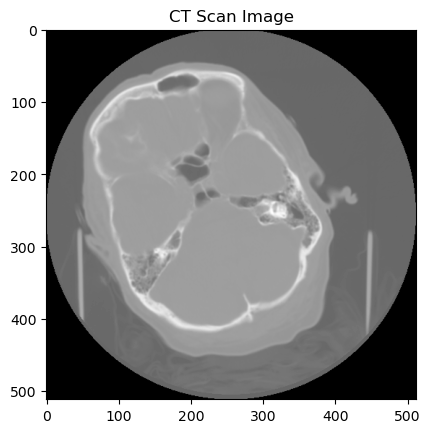

In [14]:
dcm_image = dcm_file.pixel_array
plt.imshow(dcm_image, cmap = "gray")
plt.title("CT Scan Image");

### **4.2 Visualize 3 images for each subtype and normal exams** <a id='Visualize-3-images-for-each-subtype-and-normal-exams'></a>

In [15]:
def read_dicom_files(df, cat, folder_path ,num_images=5):
    """
    
    This function is used for reading dicom files and return a list of dicom images

        Parameters:
            df (Datframe) : The dataframe that has two columns ID = "ID_<filename>_<subtype>", label = 0 or 1
            cat (str) : The subtype name such as {'epidural', 'intraparenchymal', 'intraventricular',
       'subarachnoid', 'subdural', 'normal'} 
           folder_path (Path): The root directory that contains te images 
            num_of_images (int) : The number of images to read for each subtype

        Returns:
            dicom_images (list): A list of np.array(dicom images)
            
    """
    try:
        dcm_list = []
        if cat == "normal":
            image_paths = df[df["any"]==0]["ID"].values
        else:
            image_paths = df[df[cat]==1]["ID"].values

        image_random_paths = random.sample(list(image_paths), num_images)

        for image_path in image_random_paths:
            dcm_file = pydicom.dcmread(folder_path/image_path)
            dcm_image = dcm_file.pixel_array
            dcm_list.append(dcm_image)
    except:
        raise AssertionError("Check the inputs inserted")
        
    return dcm_list

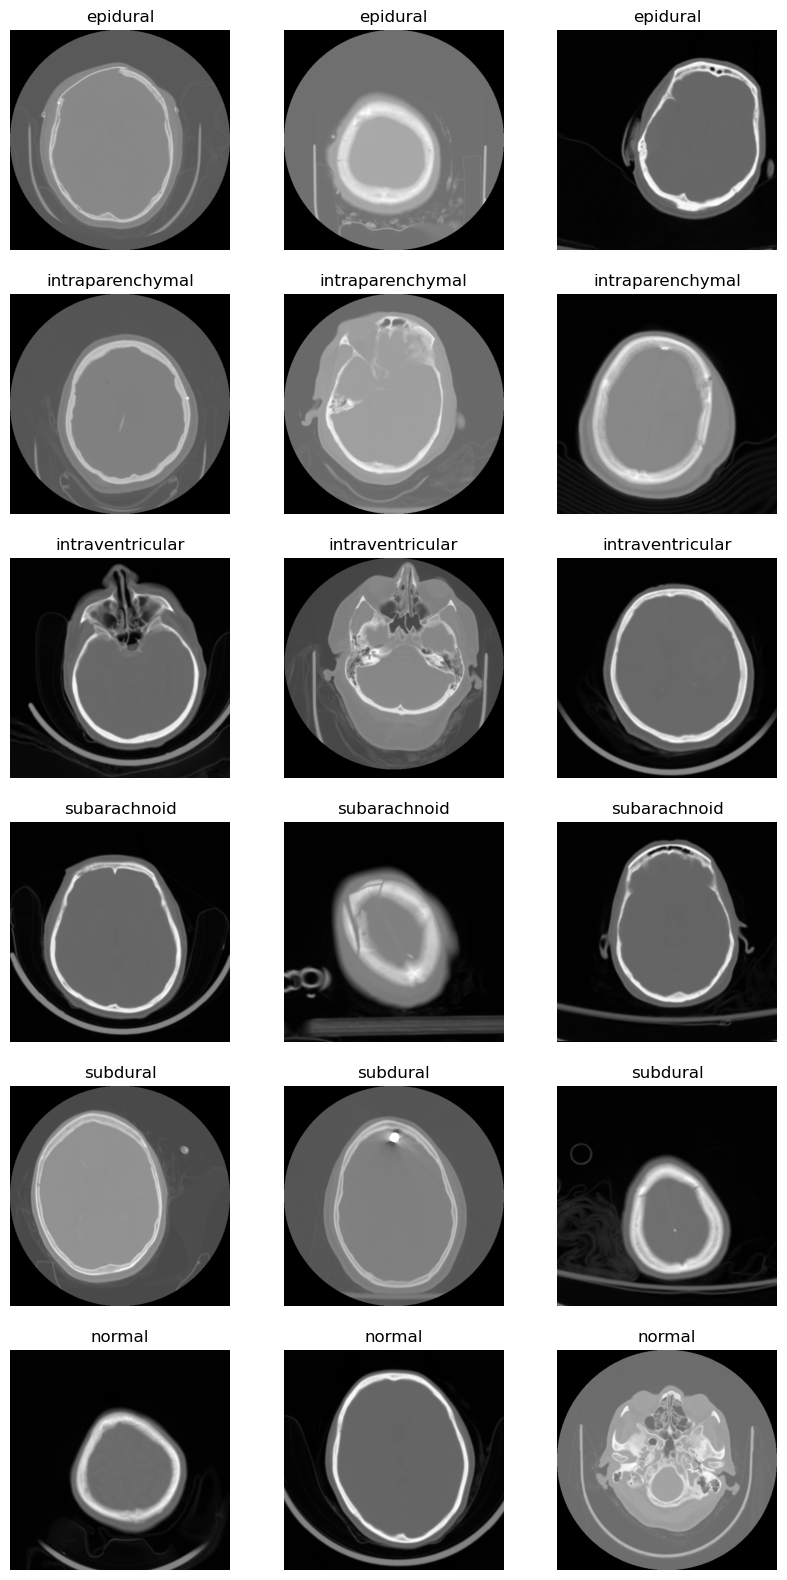

In [16]:
categories = list(train_df_new.columns[2:])
categories.append("normal")
num_images = 3
#Creatig subplots for categories
fig, ax = plt.subplots(len(categories), num_images, figsize=(10, 20))
# Flatten the axes for easy iterating
axes = ax.flatten()
i = 0
for cat in categories:
    images = read_dicom_files(df = train_df_new,
                              cat = cat,
                              folder_path = ROOT_DATA_DIR/TRAINING_IMAGES_PATH,
                              num_images=num_images
                             )
    for image in images:
            axes[i].imshow(image, cmap="gray")
            axes[i].axis("off")
            axes[i].set_title(cat)
            i+=1

As shown above, the images are not clear and the Hemorrhage cannot be realized in some images  the images need to be preprocessed such as:
- Set the window level and window width for each image to get better diagnosis of Hemorrhage
- Removing noise
- Crop the images to get the brain in the center of the image

### **4.3 DICOM Preprocessing** <a id='DICOM-Preprocessing'></a>

#### **4.3.1 Correcting Window** <a id='Correcting-Window'></a>

Regarding [See like a Radiologist with Systematic Windowing](https://www.kaggle.com/code/dcstang/see-like-a-radiologist-with-systematic-windowing) by @David Tang and [Stackoverflow article](https://stackoverflow.com/questions/8756096/window-width-and-center-calculation-of-dicom-image/8765366#8765366) by @Paolo Brandoli & @Tom Pohl, they explained the importance of correcting DICOM images windows since window level and window width are essential parameters used to control the display of grayscale values within the CT image. They play a crucial role in visualizing and interpreting the anatomical structures and pathological findings accurately

**Window Level** represents the central value of the grayscale range that will be displayed on the CT image. It determines the brightness or intensity of the image.

**Window Width** determines the range of grayscale values that will be displayed on the CT image.

To adjust the window level and window width of an image, it's required to convert the image pixels to be in Hounisfield Unit (HU) which is an intensity measurement of radio waves. We can achieve that by using the RescaleIntercept and RescaleSlop from metadata of the DICOM file.

In [29]:

def get_first_dicom_field_int(value):
    """
    
    This function is used to get the first value of multiple values of DICOM metadata fields and convert it into integer
        
        Parameters: 
            value ([float, pydicom multival.MultiValue, pydicom.valuerep.DSfloat]): Metadata field value
        
        Returns:
            value(int): Converted value into integer
    
    """
    if type(value) == pydicom.multival.MultiValue:
        return int(value[0])
    else:
        return int(value)


def transform_hu(image, intercept, slope):
    """
    
    This function is used to transfer the image pixel values to Hounisfield Unit (HU)
    
        Parameters: 
            image(np.array): It's a DICOM image
        
        Returns: 
            HU_image(np.array): A new image with HU transformation
            
    """
    hu_image = image* slope + intercept
    
    return hu_image

def window_image(image, window_level, window_width):
    """
    
    This function is used to adjust an image containing HU values with a certain range of gray shades density
    
        Parameters: 
            image (np.array): An image with HU values
            window_level(int): The centre of the grayscale range
            window_width(int): The range of grayscale
            
        Returns: 
            window_image(np.array): A new image adjusted with window leval and window width
            
    """
    lowest_value = window_level - window_width // 2
    highest_value = window_level + window_width // 2
    
    window_image = image.copy()
    
    window_image[window_image < lowest_value] = lowest_value
    window_image[window_image > highest_value] = highest_value
    
    return window_image

def window_hu_image(dcm_file, window_level=None, window_width=None):
    """
    
    This function is used to view the adjusted image by transform_HU and window_image functions
    
        Parameters: 
            dcm_file(DICOM): It's a DICOM file
            window_level(int): Windowlevel to be allied on the image 
                               if None, it will be the window_level of the DICOM file
            window_width(int): Windowwidth to be applied on the image
                                if None, it will be the window_width of the DICOM file

            
        Returns: 
            adjusted_image(np.array): An adjusted image after applying HU, window level and window width
            
    """
    if window_level and window_width:
        window_level_ = window_level
        window_width_ = window_width
    else:
        window_level_  = dcm_file.WindowCenter
        window_width_ = dcm_file.WindowWidth
        
    fields_list = [window_level_,
                   window_width_,
                   dcm_file.RescaleIntercept,
                   dcm_file.RescaleSlope
                  ]
        
    window_level, window_width, intercept, slope = [get_first_dicom_field_int(value) for value in fields_list]
    image = dcm_file.pixel_array
    hu_image = transform_hu(image, intercept, slope)
    adjusted_image = window_image(hu_image, window_level, window_width)
    return adjusted_image
    

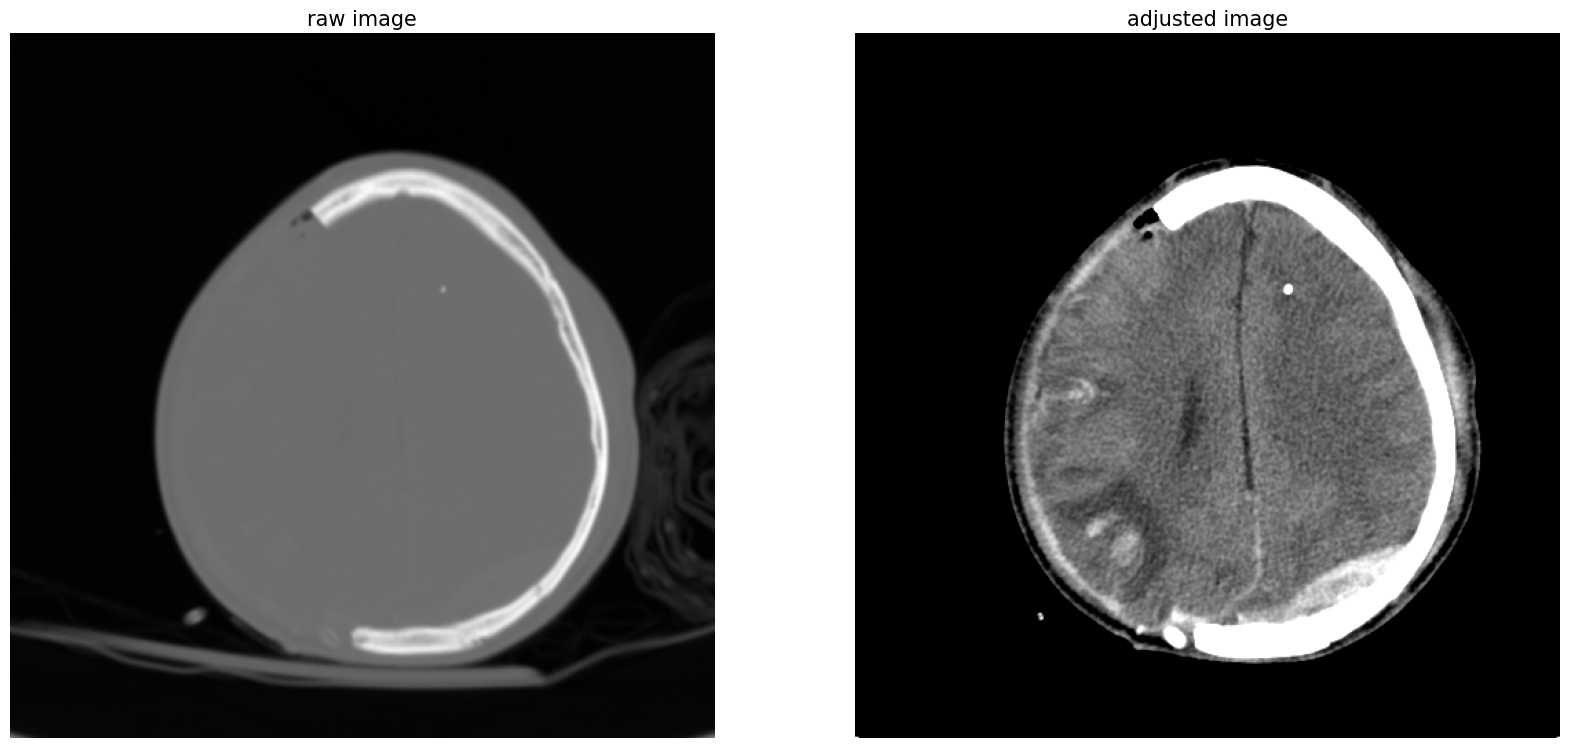

In [51]:
epidural_path = train_df_new[train_df_new["epidural"]==1]["ID"].iloc[20]
dcm_epidural_file = pydicom.dcmread(ROOT_DATA_DIR/TRAINING_IMAGES_PATH/epidural_path)
image= dcm_epidural_file.pixel_array
adjusted_image = window_hu_image(dcm_epidural_file)
images_to_plot = {"raw image":image, 
                  "adjusted image":adjusted_image
                 }

# Compare between both images
fig, ax = plt.subplots(1, 2, figsize=(20, 20))
# Flatten the axes for easy iterating
axes = ax.flatten()
i=0
# Loop through the DICOM object and plot
for name, dicom in images_to_plot.items():
    axes[i].imshow(dicom, cmap="gray")
    axes[i].set_title(name, fontsize=15)
    axes[i].axis("off")
    i+=1

Try adding the window level and window width of brain, bone and subdural as an image with 3 channels and see the result.

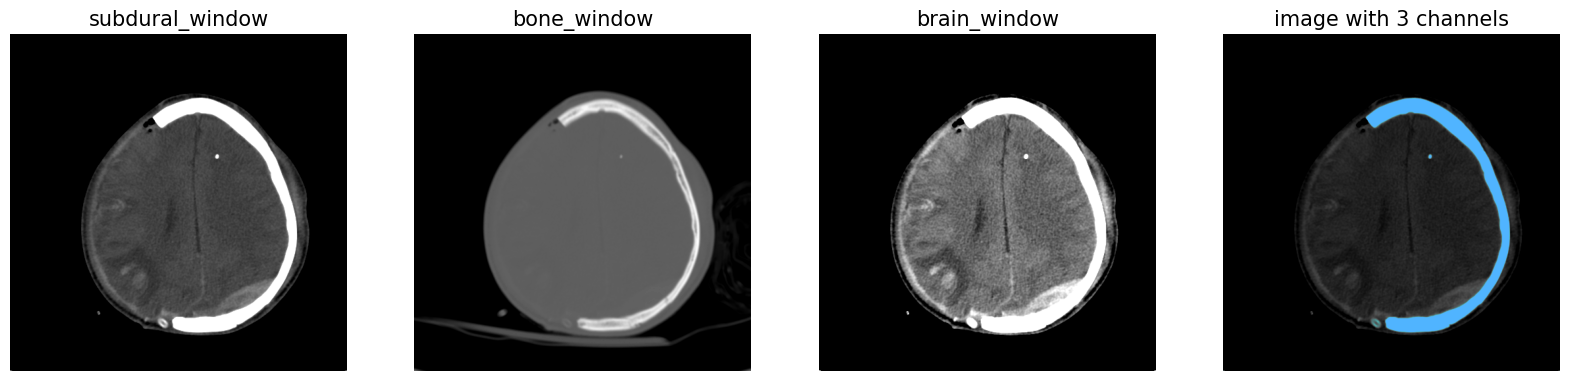

In [52]:
subdural_image = window_hu_image(dcm_epidural_file, window_level=80, window_width=200)
bone_image = window_hu_image(dcm_epidural_file, window_level=600, window_width=2800)
brain_image = window_hu_image(dcm_epidural_file, window_level=40, window_width=80)
whole_image = np.concatenate([
                                brain_image[:,:,np.newaxis],
                                subdural_image[:,:,np.newaxis],
                                bone_image[:,:,np.newaxis]
                            ],2)
images_to_plot = {"subdural_window": subdural_image,
                  "bone_window": bone_image,
                  "brain_window": brain_image,
                    "image with 3 channels":whole_image, 
                 }

# Compare between both images
fig, ax = plt.subplots(1, len(images_to_plot.keys()), figsize=(20, 20))
# Flatten the axes for easy iterating
axes = ax.flatten()
i=0
# Loop through the DICOM object and plot
for name, dicom in images_to_plot.items():
    axes[i].imshow(dicom, cmap="gray")
    axes[i].set_title(name, fontsize=15)
    axes[i].axis("off")
    i+=1

#### **4.3.2 Removing Noise** <a id='Removing-Noise'></a>

In [19]:
def denoise_image(image=None, kernel_size= (3,3)):
    """
    
    This function is used to remove the noise from the image
        
        Parameters:
            image(np.array): This image used to remove the noise from
            kernel_size(tuple): This is the kernel size used for dialation
            
        Returns:
            masked_image(np.array): This is the masked image
            mask(np.array): This is the mask used
    
    """
    kernel = np.ones(kernel_size)
    segmentation = cv2.dilate(image.astype("uint8"),  kernel)
    retval, labels = cv2.connectedComponents(segmentation)
    # Getting the number of clsases or segmentation found
    label_count = np.bincount(labels.ravel().astype(np.int))
    #the first class is background, we won't use it
    label_count[0] = 0

    mask = labels == label_count.argmax()
    mask = cv2.dilate(mask.astype("uint8"), kernel)
    masked_image = mask* image
    return  masked_image, mask

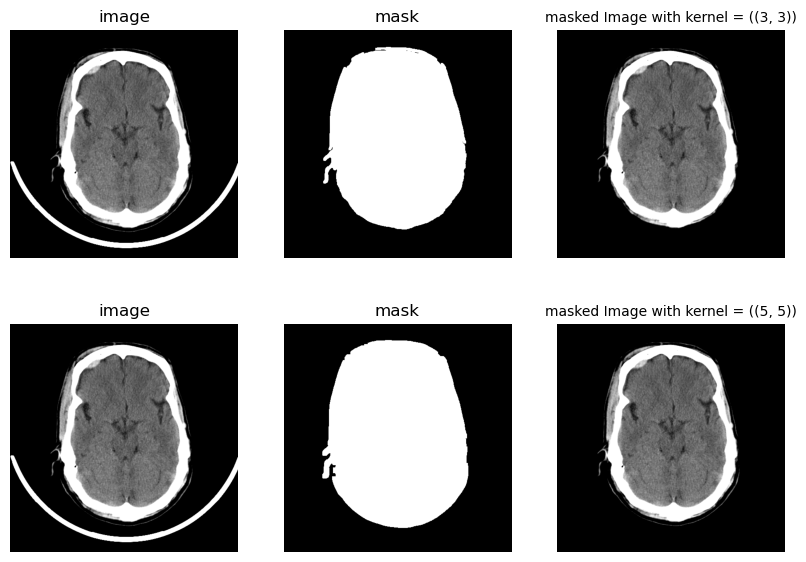

In [20]:
epidural_path = train_df_new[train_df_new["epidural"]==1]["ID"].iloc[10]
dcm_epidural_file = pydicom.dcmread(ROOT_DATA_DIR/TRAINING_IMAGES_PATH/epidural_path)
image= dcm_epidural_file.pixel_array
adjusted_image = window_hu_image(dcm_epidural_file)

# Compare between both images
fig, ax = plt.subplots(2, 3, figsize=(10, 7))
# Flatten the axes for easy iterating
axes = ax.flatten()
kernel_value = 3
# Loop through the DICOM object and plot
for i in range(0,4,3):
    masked_image, mask = denoise_image(image=adjusted_image, 
                                       kernel_size= (kernel_value,kernel_value)
                                      )
    axes[i].imshow(adjusted_image, cmap="gray")
    axes[i].set_title("image", fontsize=12)
    axes[i].axis("off")
    axes[i+1].imshow(mask, cmap="gray")
    axes[i+1].set_title("mask", fontsize=12)
    axes[i+1].axis("off")
    axes[i+2].imshow(masked_image, cmap="gray")
    axes[i+2].set_title(f"masked Image with kernel = ({kernel_value,kernel_value})", fontsize=10)
    axes[i+2].axis("off")
    i+=3
    kernel_value +=2


As hown above the kernel_size (3,3) has the best result.

In [21]:
masked_image, _ = denoise_image(image=adjusted_image,
                                kernel_size= (3,3)
                               )

#### **4.3.3 Cropping and Padding** <a id='Cropping-and-Padding'></a>

These two function are used to:
- Crop the image to get the object in the middle of the image
- Pad the image to preserve the previous size of this image

In [22]:
def crop_image(image):
    """
    
    This functio is used to crop the image to filt the object in the center
        
        Parameters:
            image(np.array): This is the image needed to be cropped
        
        Returns:
            cropped_image(np.array): This is the final output
        
    """
    # Create a mask with the background pixels
    mask = image == 0
    
    # gitting the coordinates of the object which pixel values !=0
    
    coords = np.transpose(np.nonzero(~mask))

    # Find the object area
    x_min, y_min = np.min(coords, axis = 0)
    x_max, y_max = np.max(coords, axis=0)

    # Crop image
    cropped_image = image[x_min:x_max,
                          y_min:y_max]

    return cropped_image

In [23]:
def pad_image(image, height, width):
    """
    
    This function is used to pad the image to reach the size of height x width
    
        Parameters:
            image(np.array): This is the image to be padded
            height(int): This is the target height
            width(int): This is the target width
            
        Returns:
            padded_image(np.array): This is the final output
    
    """
    # check the image shape to be sure it's not higher than the target size
    prev_height, prev_width = image.shape[:2]
    if prev_height > height and prev_width > width:
        return image
    # Getting the size of padding
    pad_left = int((width - prev_width) / 2)
    pad_top = int((height - prev_height) / 2)
    
    # Generating the image with new size
    padded_image = np.zeros(shape = (height, width),
                            dtype=np.int16
                           )
    
    padded_image[pad_top : pad_top + prev_height, 
                 pad_left : pad_left + prev_width] = image
    
    return padded_image


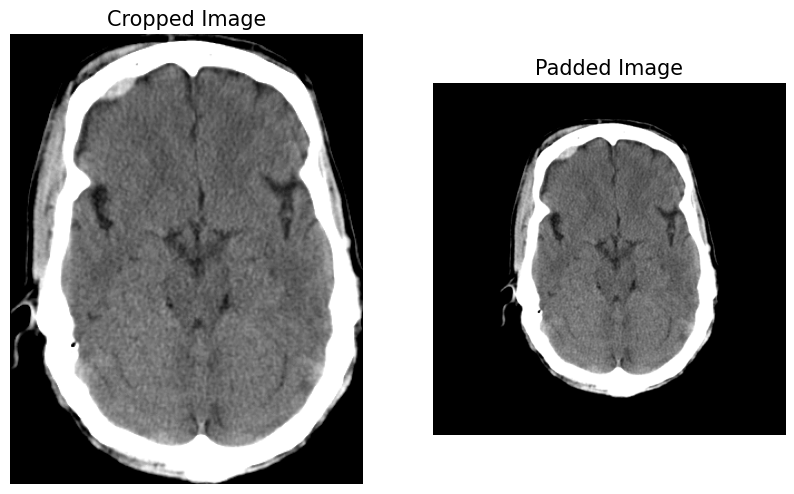

In [24]:
cropped_image = crop_image(masked_image)
padded_image = pad_image(cropped_image, height=512, width=512)
plot_dict = {"Cropped Image":cropped_image,
             "Padded Image":padded_image
            }

# Compare between both images
fig, ax = plt.subplots(1, 2, figsize=(10, 10))

# Flatten the axes for easy iterating
axes = ax.flatten()
i = 0
# Loop through the DICOM object and plot
for name, img in plot_dict.items() :
    axes[i].imshow(img, cmap="gray")
    axes[i].set_title(name, fontsize=15)
    axes[i].axis("off")
    i+=1

#### **4.3.4 Put Them Together** <a id='Put-Them-Together'></a>

In [25]:
def preprocess_pipline(dcm_path):
    """
    
    This function applies the preprocessing steps of DICOM image which are:
    1- Transform image to HU and apply image windowing
    2- Remove noise
    3- Put the brain in the image center
    
    Parameters:
        dcm_path(str | Path): The absolute path with dicom file name
        
    Returns:
        image(np.array): The original image
        adjusted_image(np.array): The image with HU conversion and windowing
        masked_image(np.array): The image with noise removal
        padded_image(np.array): The image with centered brain and resized to the original shape
    
    """
    dcm_file = pydicom.dcmread(dcm_path)
    image = dcm_file.pixel_array
    adjusted_image = window_hu_image(dcm_file)
    masked_image,mask = denoise_image(adjusted_image)
    cropped_image = crop_image(masked_image)
    padded_image = pad_image(cropped_image,
                             height = image.shape[0],
                             width = image.shape[1]
                            )
    return image, adjusted_image, masked_image, padded_image
    

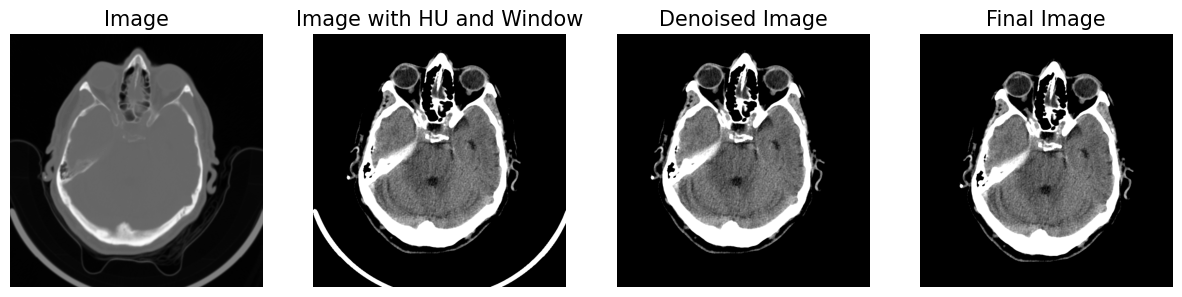

In [26]:
subdural_path = train_df_new[train_df_new["subdural"]==1]["ID"].iloc[500]
dcm_path = ROOT_DATA_DIR/TRAINING_IMAGES_PATH/subdural_path
plot_list = list(preprocess_pipline(dcm_path))
name_list = ["Image", "Image with HU and Window", "Denoised Image", "Final Image"]
# Compare between both images
fig, ax = plt.subplots(1, len(name_list), figsize=(15, 10))
# Flatten the axes for easy iterating
axes = ax.flatten()
# Loop through the DICOM object and plot
for i, (img, name) in enumerate(zip(plot_list, name_list)) :
    axes[i].imshow(img, cmap="gray")
    axes[i].set_title(name, fontsize=15)
    axes[i].axis("off")